## CNN 

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import Functions as func
import var
import Viz
from keras.wrappers.scikit_learn import KerasClassifier

Using plaidml.keras.backend backend.


In [2]:
### best is model weights 2

In [3]:
def get_conv_model_normal(dim):
    
    inp_shape = dim
    act = 'relu'
    drop = .25
    kernal_reg = regularizers.l1(.001)
    dil_rate = 2
    optimizer = Adam(lr = .001)
    
    model = Sequential() 
    
    model.add(Conv2D(64, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg,
                     kernel_initializer = 'he_uniform',  padding = 'same', name = 'Input_Layer'))
#     model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),  strides = (3,3)))
    
    
    model.add(Conv2D(64, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
#     model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))
    

    
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))

    
    model.add(Flatten())

    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dropout(drop))

    model.add(Dense(3, activation='softmax', name = 'Output_Layer'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model 


In [4]:
x_train, x_test, y_train, y_test = func.get_samples('normal')


In [ ]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


augment = True 
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=14)
model_checkpoint = ModelCheckpoint('../models/CNN-ModelCheckpointWeights3.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 3, mode = 'min')
epochs = 100
batch_size = 16
if var.img_type == 'grey': 
    dim = (x_train.shape[1], x_train.shape[2], 1)
else: 
    dim = (x_train.shape[1], x_train.shape[2], 3)
    
normal_model = get_conv_model_normal(dim =dim)

if augment: 
    augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                           horizontal_flip = True, shear_range = .15, 
                                     fill_mode = 'nearest', zoom_range = .15)
    augmentation.fit(x_train)
    normal_history = normal_model.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
                epochs = epochs, 
         callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)
else: 
    
    normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
                epochs = epochs, 
         callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


In [ ]:
print(normal_model.summary())

### Loss & Accuracy

In [ ]:
Viz.plot_loss_accuracy(normal_history)

### AUC and ROC Curves

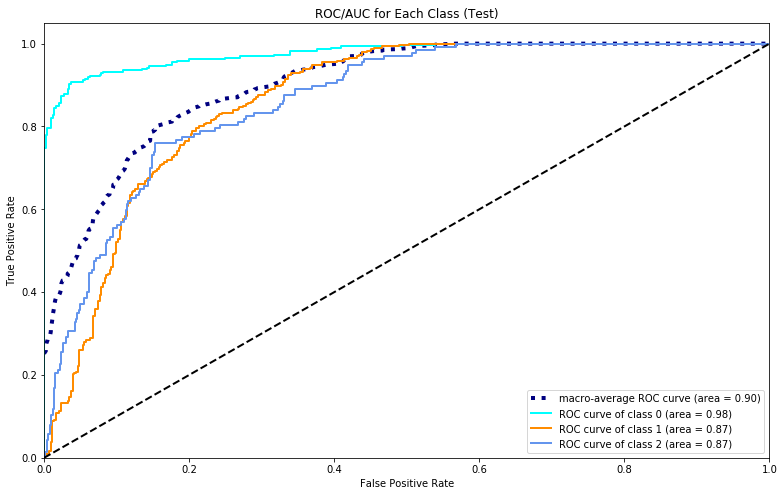

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9129662522202485
HandGun: 0.7412353923205343
Rifle: 0.5734265734265734


In [11]:
if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('../models/CNN-ModelCheckpointWeights3.h5') #load the best weights before overfitting
 


    
Viz.plot_roc_auc(normal_model, x_test, y_test)

### Confusion Matrix

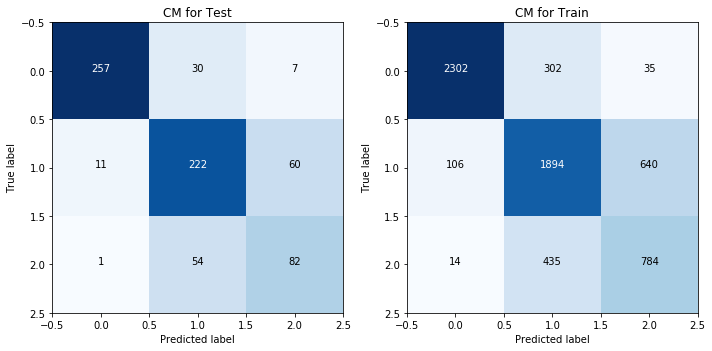

In [12]:
if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('../models/CNN-ModelCheckpointWeights3.h5') #load the best weights before overfitting





y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'])


In [ ]:
assert False

#### Test on Google Data


In [5]:
import cv2
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [6]:
base_path = '../Tests/Photos'

if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('../models/CNN-ModelCheckpointWeights3.h5')


for file in os.listdir(base_path): 
    if file == '.ipynb_checkpoints':
        continue
    full_path = f'{base_path}/{file}'
    img = func.get_image_value(full_path, var.norm_dimension, var.img_type)
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    pred = normal_model.predict(img)[0]
    print(f'{file}\t\t{np.argmax(pred)}\t\t{pred.max()}\t\t{pred}')

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


AR.jpg		2		0.6100225448608398		[0.00075671 0.3892207  0.61002254]
NonGun.jpeg		2		0.6953375339508057		[0.00487827 0.29978415 0.69533753]
NonGun2.jpg		1		0.49281591176986694		[0.0392661  0.4928159  0.46791798]
Pistol.jpg		1		0.9195637106895447		[3.782598e-04 9.195637e-01 8.005805e-02]
Pistol2.jpg		2		0.9673222899436951		[5.034534e-07 3.267724e-02 9.673223e-01]
Pistol3.jpg		1		0.6080151200294495		[0.00324698 0.6080151  0.38873795]
Pistol4.png		2		0.6341588497161865		[0.01995742 0.34588367 0.63415885]


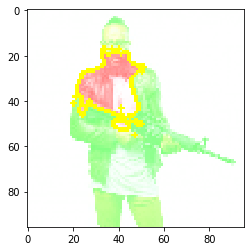

In [7]:
#model 3
if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        

img = func.get_image_value('../Tests/Photos/AR.jpg', var.norm_dimension, var.img_type)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(img, normal_model.predict, top_labels = 5, hide_color = 0, 
                                         num_samples = 1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = False,
                                           num_features = 10, hide_rest = False)
plt.imshow(mark_boundaries(temp/2 + .5, mask))

In [ ]:
func.get_img_prediction_bounding_box('../Tests/Photos/Pistol3.jpg', normal_model, var.norm_dimension)

In [ ]:
assert False

In [8]:
from tqdm import tqdm
def get_vid_prediction_bounding_box(path, model, dim): 
    vid = cv2.VideoCapture(path)
    total_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    pbar = tqdm(total = total_frames, desc = f'Splitting Video Into {total_frames} Frames')
    images = [] 
    sucess =1 
    while True: 
        try:
            success, img = vid.read() 
            img = cv2.resize(img, dim, interpolation = cv2.INTER_CUBIC)
            images.append(img)
            pbar.update(1)
        except: 
            break
        

    pbar.close()
    print(total_frames)
    print(np.array(images).shape)
    return np.array(images)
   



images = get_vid_prediction_bounding_box('../Tests/Videos/Pistol2.mp4', normal_model, var.norm_dimension)
predictions = normal_model.predict(images)

Splitting Video Into 720 Frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 720/720 [00:02<00:00, 305.53it/s]


720
(720, 96, 96, 3)


In [9]:
def window_prob_func(pred, img, model, dim):
    category_dict = {0: 'No Weapon', 1: 'Handgun', 2: 'Rifle'}
    cat_index = np.argmax(pred)
    cat = category_dict[cat_index]
    
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process() 

    windows = []
    locations = []
    for x, y, w,h in rects: 
        startx = x 
        starty = y 
        endx = x+w 
        endy = y+h 
        roi = img[starty:endy, startx:endx]
        roi = cv2.resize(roi, dsize =dim, interpolation = cv2.INTER_CUBIC)
        windows.append(roi)
        locations.append((startx, starty, endx, endy))

    windows = np.array(windows)

    predictions = model.predict(windows)

    clone = img.copy()
    cat_predictions = predictions[:,cat_index]
    pred_max_idx = np.argmax(cat_predictions)
    pred_max = cat_predictions[pred_max_idx]
    
    pred_max_window = locations[pred_max_idx]
    startx, starty, endx, endy = pred_max_window
    
    
    return (cat, pred_max, (startx, starty, endx, endy))

pbar = tqdm(list(zip(predictions, images)), desc= 'Getting Base Prediction and Extracting Sliding Window... Sit Back, This Will Take A While')
windows_prob = [window_prob_func(pred, img, normal_model, var.norm_dimension) for (pred, img) in pbar]

Getting Base Prediction and Extracting Sliding Window... Sit Back, This Will Take A While: 100%|████████████████████████████████████████████████████████| 720/720 [01:57<00:00,  6.11it/s]


In [10]:
import pickle 
pickle.dump(windows_prob, open('../Pickles/WindowsPropPistol_CNN.p', 'wb'))

for i in windows_prob: 
    if i[0] != 'No Weapon': 
        print(i)

('Rifle', 1.0, (41, 0, 88, 60))
('Rifle', 1.0, (30, 53, 96, 96))
('Rifle', 1.0, (51, 0, 96, 69))
('Rifle', 1.0, (33, 0, 96, 96))
('Rifle', 1.0, (83, 0, 96, 67))
('Rifle', 1.0, (0, 0, 96, 96))
('Rifle', 1.0, (49, 56, 85, 96))
('Rifle', 1.0, (0, 0, 96, 96))
('Rifle', 1.0, (0, 0, 96, 96))
('Rifle', 1.0, (0, 0, 96, 96))
('Rifle', 1.0, (85, 47, 96, 59))
('Rifle', 1.0, (0, 0, 49, 96))
('Rifle', 1.0, (57, 47, 96, 96))
('Rifle', 1.0, (27, 17, 90, 96))
('Rifle', 1.0, (58, 52, 96, 96))
('Rifle', 1.0, (68, 53, 96, 96))
('Rifle', 1.0, (60, 52, 96, 96))
('Rifle', 1.0, (0, 0, 96, 96))
('Rifle', 1.0, (38, 36, 90, 96))
('Rifle', 1.0, (47, 3, 96, 96))
('Rifle', 1.0, (65, 58, 85, 83))
('Rifle', 1.0, (0, 0, 68, 96))
('Rifle', 1.0, (64, 56, 92, 96))
('Rifle', 1.0, (38, 3, 96, 96))
('Rifle', 1.0, (77, 38, 96, 96))
('Rifle', 1.0, (84, 86, 96, 96))
('Rifle', 1.0, (59, 0, 96, 78))
('Rifle', 1.0, (37, 0, 96, 96))
('Rifle', 1.0, (0, 0, 38, 96))
('Handgun', 1.0, (0, 0, 93, 96))
('Handgun', 1.0, (0, 0, 96, 96))
(

('Rifle', 1.0, (53, 45, 74, 83))
('Rifle', 1.0, (62, 74, 72, 96))
('Rifle', 1.0, (66, 5, 93, 57))
('Rifle', 1.0, (0, 0, 96, 96))
('Rifle', 1.0, (42, 38, 96, 96))
('Rifle', 1.0, (31, 29, 49, 55))
('Rifle', 1.0, (57, 6, 96, 96))
('Rifle', 1.0, (32, 35, 95, 96))
('Rifle', 1.0, (0, 0, 85, 96))
('Rifle', 1.0, (0, 0, 96, 96))
('Rifle', 1.0, (72, 44, 96, 84))
('Rifle', 1.0, (61, 67, 79, 86))
('Rifle', 1.0, (24, 27, 43, 51))
('Rifle', 1.0, (67, 6, 96, 59))
('Rifle', 1.0, (68, 7, 96, 59))
('Rifle', 1.0, (31, 30, 77, 96))
('Rifle', 1.0, (72, 73, 96, 96))
('Rifle', 1.0, (76, 7, 96, 58))
('Rifle', 1.0, (24, 21, 43, 45))
('Rifle', 1.0, (70, 22, 96, 58))
('Rifle', 1.0, (0, 0, 96, 96))
('Rifle', 1.0, (35, 30, 90, 96))
('Rifle', 1.0, (0, 0, 96, 96))
('Rifle', 1.0, (34, 32, 90, 78))
('Rifle', 1.0, (63, 72, 96, 96))
('Rifle', 1.0, (24, 7, 96, 87))
('Rifle', 1.0, (69, 6, 96, 59))
('Rifle', 1.0, (19, 22, 67, 61))
('Rifle', 1.0, (12, 0, 36, 20))
('Rifle', 1.0, (91, 31, 96, 62))
('Rifle', 1.0, (0, 0, 15, 32

('Rifle', 1.0, (63, 75, 84, 93))
('Rifle', 1.0, (0, 0, 96, 96))
('Rifle', 1.0, (0, 0, 85, 96))
('Rifle', 1.0, (42, 0, 81, 36))
('Rifle', 1.0, (83, 0, 96, 60))
('Rifle', 1.0, (39, 24, 79, 54))
('Rifle', 1.0, (53, 30, 96, 96))
('Rifle', 1.0, (0, 0, 60, 96))
('Rifle', 1.0, (49, 17, 57, 46))
('Rifle', 1.0, (49, 14, 80, 55))
('Rifle', 1.0, (16, 0, 83, 96))
('Rifle', 1.0, (58, 16, 63, 47))
('Rifle', 1.0, (23, 0, 80, 42))
('Rifle', 1.0, (8, 56, 22, 73))
('Rifle', 1.0, (36, 0, 85, 52))
('Rifle', 1.0, (8, 56, 32, 73))
('Rifle', 1.0, (35, 56, 58, 72))
('Rifle', 1.0, (37, 0, 73, 52))
('Rifle', 1.0, (53, 13, 83, 81))
('Rifle', 1.0, (35, 56, 58, 72))
('Rifle', 1.0, (63, 17, 78, 46))
('Rifle', 1.0, (63, 16, 72, 46))
('Rifle', 1.0, (35, 0, 73, 52))
('Rifle', 1.0, (68, 35, 87, 96))
('Rifle', 1.0, (71, 74, 83, 96))
('Rifle', 1.0, (0, 0, 70, 96))
('Rifle', 1.0, (78, 0, 96, 96))
('Rifle', 1.0, (74, 84, 84, 96))
('Rifle', 1.0, (28, 56, 57, 72))
('Rifle', 1.0, (37, 0, 82, 96))
('Rifle', 1.0, (40, 0, 86, 96

-1

In [25]:
vid_dim = (224,224)
vid_dim = var.norm_dimension
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('../Tests/VideoTests/TestCNN.mp4',fourcc, 10, vid_dim)


for (cat, (startx, starty, endx, endy)), img in zip(windows_prob, images): 
    clone = img.copy()
    if cat == 'No Weapon':
#         clone = cv2.resize(clone, dsize =vid_dim, interpolation = cv2.INTER_CUBIC)      
        out.write(clone)
    else: 
        cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,0,255),2)
#         clone = cv2.resize(clone, dsize =vid_dim, interpolation = cv2.INTER_CUBIC)     
        out.write(clone)
out.release()
cv2.destroyAllWindows()

In [ ]:
assert False

In [ ]:
if var.img_type == 'grey': 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('../models/CNN-ModelCheckpointWeights2.h5')

img = cv2.imread('../TestImages/AR.jpg')
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process() 

windows = []
locations = []
for x, y, w,h in rects: 
    startx = x 
    starty = y 
    endx = x+w 
    endy = y+h 
    roi = img[starty:endy, startx:endx]
    roi = cv2.resize(roi, dsize =var.norm_dimension, interpolation = cv2.INTER_CUBIC)
    windows.append(roi)
    locations.append((startx, starty, endx, endy))
    


In [ ]:
windows = np.array(windows[:2000])

predictions = normal_model.predict(windows)

In [ ]:
# for i in predictions:
#     print(i)

In [ ]:
clone = img.copy()
new_loc = [] 
new_prob = [] 
no_gun = predictions[:, 0].sum()
handgun = predictions[:,1].sum()
rifle = predictions[:,2].sum()
sum_array = np.array([no_gun, handgun, rifle])
index_unit = np.argmax(sum_array)
cat_types = ['No Gun', 'Handgun', 'Rifle']
print(index_unit)
print(no_gun, handgun, rifle)
new_locations = []
for idx, i in enumerate(predictions):
    category = i[index_unit]
    if category > .5:
        startx, starty, endx, endy = locations[idx]
        new_locations.append([startx, starty, endx, endy])
        new_loc.append(locations[idx])
        new_prob.append(category)

new_locations = np.array(new_locations)

startx = int(new_locations[:,0].mean())
starty =int( new_locations[:,1].mean())
endx = int(new_locations[:,2].mean())
endy = int(new_locations[:,3].mean())


# startx = int(np.median (new_locations[:,0]))
# starty =int( np.median (new_locations[:,1]))
# endx = int(np.median (new_locations[:,2]))
# endy = int(np.median(new_locations[:,3]))

prob_avg = np.array(new_prob).mean()


cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,255,0),2)

text = f'{cat_types[index_unit]}: {int(prob_avg*100)}'
cv2.putText(clone, text, (startx, starty), cv2.FONT_HERSHEY_SIMPLEX, .45, (0,255,0),2)
   
    
cv2.imshow('test', clone)
cv2.waitKey(0)

In [ ]:
assert False

In [ ]:
clone = img.copy()
  
startx, starty, endx, endy = new_loc[boxid]
cv2.rectangle(clone, (startx, starty), (endx, endy),  (0,255,0),2)
text = f'Weapon: {i*100}'
cv2.putText(clone, text, (startx, y), cv2.FONT_HERSHEY_SIMPLEX, .45, (0,255,0),2)
cv2.imshow('test', clone)
cv2.waitKey(0)

In [ ]:
clone = img.copy()
roi = clone[starty:endy, startx:endx]
roi = cv2.resize(roi, dsize =var.dimension, interpolation = cv2.INTER_CUBIC)
# cv2.imshow('test', roi)
# cv2.waitKey(0)
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(roi, normal_model.predict, top_labels = 5, hide_color = 0, 
                                         num_samples = 1000)


temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = False,
                                           num_features = 10, hide_rest = False)
plt.imshow(mark_boundaries(temp/2 + .5, mask))